In [18]:
import numpy as np
import math
from scipy import fft
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [2]:
def RK4(f, current_state: tuple, step_size: float = 0.01) -> float:
    """Performs Runge-Kunta 4th Order for a Single Step

    Args:
        f (_type_): A Python function.
        current_state (tuple): Inputs to the Python Functions applicable
        step_size (float, optional): The step size used in RK4. Defaults to 0.01.

    Returns:
        float: A new value, f(current_state+step_size)
    """    
    k1 = step_size * f(*current_state)

    k2 = step_size * f(
        *[current_state[i] + k1 * 0.5 for i in range(len(current_state))]
    )
    k3 = step_size * f(
        *[current_state[i] + k2 * 0.5 for i in range(len(current_state))]
    )
    k4 = step_size * f(*[current_state[i] + k3 for i in range(len(current_state))])

    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

In [9]:
class baseSIR:
    def __init__(self, beta: float, gamma: float, I0: float):
        """
        Initialize population-dependent base SIR model with model parameters and initial conditions
        """
        self.beta = beta
        self.gamma = gamma

        self.S = 1 - I0
        self.I = I0
        self.R = 0

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I

    def dIdt(self, S, I) -> float:
        """
        Differential equation for infected population.
        """
        return self.beta * S * I - self.gamma * I

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method.
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I

        self.R = 1 - self.S - self.I

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.linspace(0, t, int(t / dt) + 1)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, I_values, R_values))


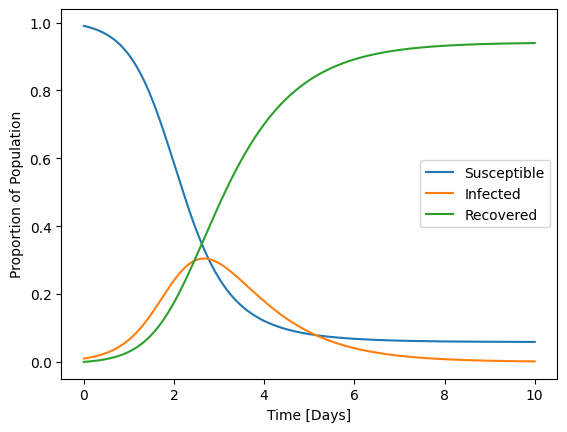

In [10]:
arbitrary_model = baseSIR(beta=3, gamma=1, I0=0.01)
arbitrary_data = arbitrary_model.numerical_integration(t=10, dt=0.001)
arbitrary_time = arbitrary_data[:,0]

plt.plot(arbitrary_time, arbitrary_data[:, 1], label="Susceptible")
plt.plot(arbitrary_time, arbitrary_data[:, 2], label="Infected")
plt.plot(arbitrary_time, arbitrary_data[:, 3], label="Recovered")
plt.xlabel('Time [Days]')
plt.ylabel('Proportion of Population')
plt.legend()
plt.show()

In [21]:
arbitrary_data[-1,:]

array([10.        ,  0.05895309,  0.00154744,  0.93949947])

In [6]:
beta_values = np.linspace(0.25, 1, 5)
gamma_values = np.linspace(0.25, 1, 5)

epidemic_combinations = [
    (beta, gamma) for beta in beta_values for gamma in gamma_values if beta / gamma > 1
]

extinction_combinations = [
    (beta, gamma) for beta in beta_values for gamma in gamma_values if beta / gamma < 1
]

In [7]:
def phase_diagram(
    SIR,
    beta,
    gamma,
    I0_values,
    t=300,
    dt=0.01,
    title=None,
    subplot_index=None,
    **kwargs,
):
    """Plots one (or many) Phase Diagrams for same values of the SIR parameters. 

    Args:
        SIR (_type_): Any SIR model that is simiarily defined as baseSIR()
        beta (_type_): Transmission parameter
        gamma (_type_): Recovery parameter
        I0_values (_type_): An array of I(0) values
        t (int, optional): Length of time for which the SIR model is integrated. Defaults to 300.
        dt (float, optional): Step size for RK4. Defaults to 0.01.
        title (_type_, optional): Title of the Phase Diagram Plot. Defaults to None.
        subplot_index (_type_, optional): For subplots. Defaults to None.
    """    
    if subplot_index is not None:
        plt.subplot(2, 3, subplot_index)  # 2 rows, 3 columns

    plt.plot([1, 0], [0, 1], "r-", linewidth=1, alpha=0.7, label="Diagonal")

    for I0 in I0_values:
        model_instance = SIR(beta=beta, gamma=gamma, I0=I0, **kwargs)
        data = model_instance.numerical_integration(t=t, dt=dt)
        plt.plot(data[:, 1], data[:, 2], color="lightblue", linewidth=1.5, alpha=0.7)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Susceptible (S)")
    plt.ylabel("Infected (I)")
    plt.title(title, fontsize=10)
    plt.grid(True, color="gray", linestyle="--", linewidth=0.5)
    plt.gca().set_facecolor("whitesmoke")

KeyboardInterrupt: 

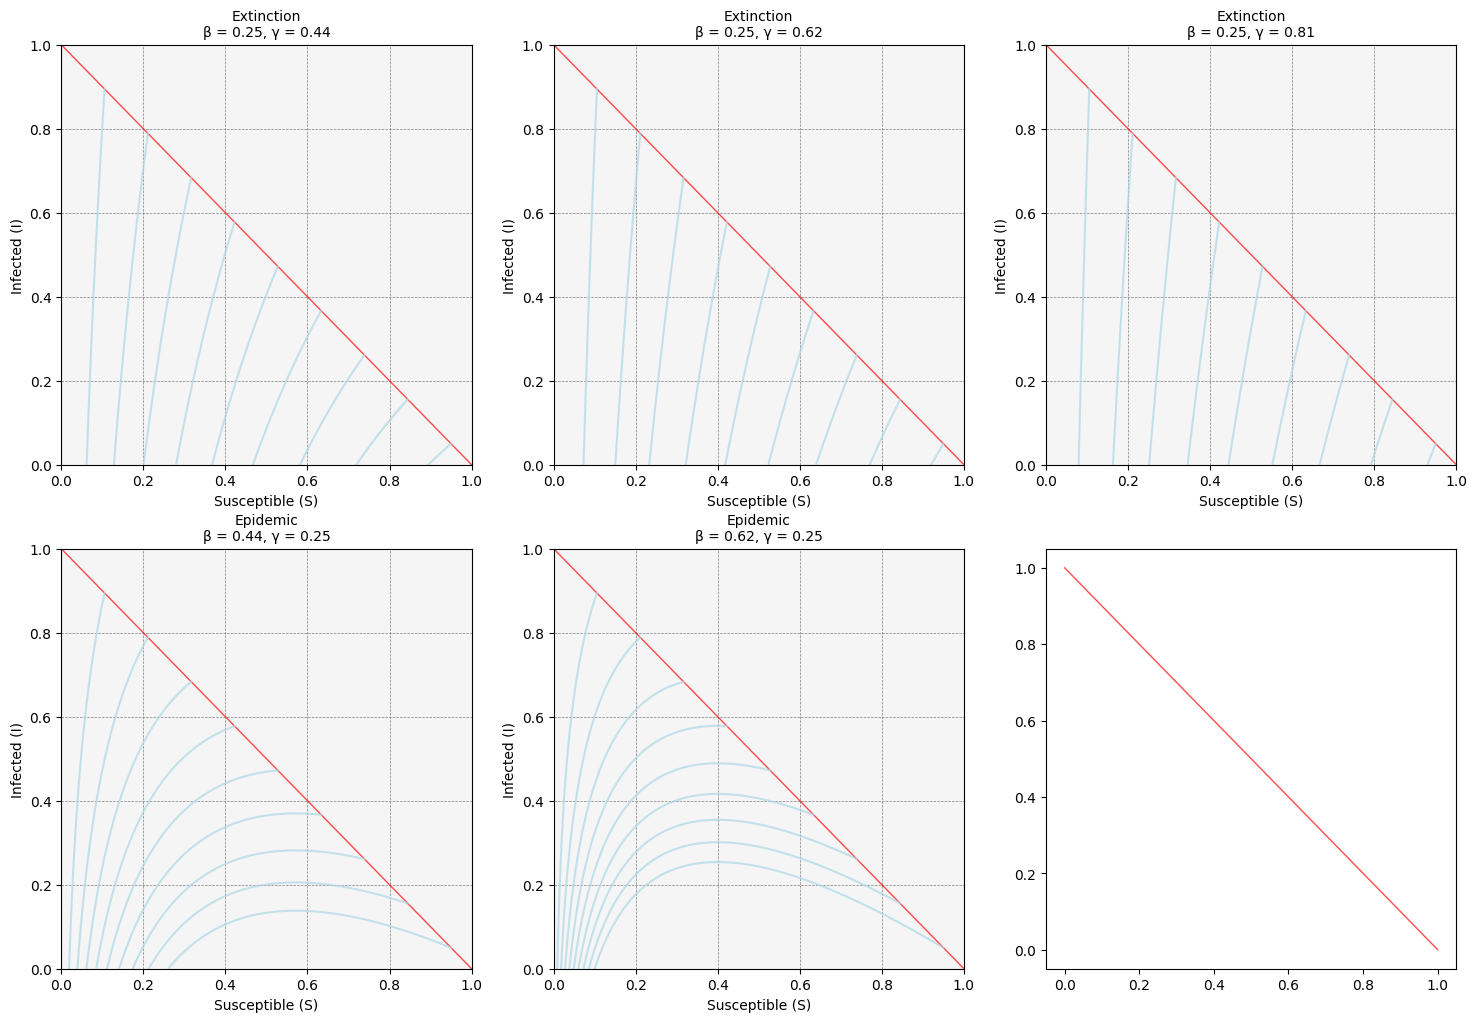

In [8]:
I0_values = np.linspace(0.05, 1, 10)

plt.figure(figsize=(18, 12))

for i, (beta, gamma) in enumerate(extinction_combinations[:3]):
    phase_diagram(
        baseSIR,
        beta,
        gamma,
        I0_values,
        t=300,
        dt=0.001,
        title=f"Extinction\nβ = {beta:.2f}, γ = {gamma:.2f}",
        subplot_index=i + 1,
    )

for i, (beta, gamma) in enumerate(epidemic_combinations[:3]):
    phase_diagram(
        baseSIR,
        beta,
        gamma,
        I0_values,
        t=300,
        dt=0.001,
        title=f"Epidemic\nβ = {beta:.2f}, γ = {gamma:.2f}",
        subplot_index=i + 4,
    )


plt.suptitle("Phase Diagrams for Different β and γ Values", fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.show()

In [11]:
class solverSIR:
    def __init__(self, SIR, loss_fn, init_params, **kwargs):
        """Solves the SIR model parameter for an observed infectand population

        Args:
            SIR (_type_): Any SIR model that is simiarily defined as baseSIR()
            loss_fn (_type_): A loss function.
            init_params (_type_): Initial guesses for the model parameters
        """        
        self.classSIR = SIR
        self.loss_fn = loss_fn
        self.params = np.array(init_params)
        self.kwargs = kwargs

    def computeLoss(self, params, obsS):
        """Compute loss value associated with model with parameters

        Args:
            params (_type_): Current state of model parameters
            obsS (_type_): Observed infectand array
        Returns:
            loss_t: The loss associated with the model and the observed infectand array
        """        
        time = len(obsS)

        model_t = self.classSIR(*params, **self.kwargs).numerical_integration(time - 1)

        fitS_t = model_t[np.isin(model_t[:, 0], np.arange(0, time + 1)), 2]

        loss_t = self.loss_fn(obsS, fitS_t)

        return loss_t

    def computeGrad(self, obsS, params, epsilon=1e-8):
        """Computes the gradient

        Args:
            obsS (_type_): Observed infectand array
            params (_type_): Current state of model parameters
            epsilon (_type_, optional): Step size for the model parameter. Defaults to 1e-8.

        Returns:
            grad: Returns gradient
        """        
        grad = np.zeros_like(params)

        loss_t = self.computeLoss(params, obsS)

        for i, _ in enumerate(params):
            params[i] += epsilon

            loss_dt = self.computeLoss(params, obsS)

            grad[i] = (loss_dt - loss_t) / epsilon

            params[i] -= epsilon  # Restore the original parameter

        return grad

    def optimize(self, obsS, learning_rate=0.01, max_iterations=1000, epsilon=1e-8):
        """Performs AdaGrad to find optimal model parameters with lowest loss

        Args:
            obsS (_type_): Observed infectand array
            learning_rate (float, optional): The learning rate used by AdaGrad. Defaults to 0.01.
            max_iterations (int, optional): Maximum number of iterations before AdaGrad terminates. Defaults to 1000.
            epsilon (_type_, optional): Step size for the model parameter. Defaults to 1e-8.

        Returns:
            _type_: _description_
        """        
        params = np.array(self.params, dtype=float)

        lowest_loss = float("inf")
        best_params = params.copy()

        # Implement Adagrad
        accumulated_grad_squares = np.zeros_like(params)

        for iteration in range(max_iterations):
            grad = self.computeGrad(obsS, params)

            params -= learning_rate * grad

            accumulated_grad_squares += grad**2

            adjusted_grad = grad / (np.sqrt(accumulated_grad_squares) + epsilon)
            params -= learning_rate * adjusted_grad

            current_loss = self.computeLoss(params, obsS)

            prev_loss = current_loss

            if current_loss < lowest_loss:
                lowest_loss = current_loss
                best_params = params.copy()

            if iteration % 100 == 0:
                print(
                    f"Iteration {iteration}: Lowest Loss = {lowest_loss}, Best Parameters = {best_params}"
                )

        self.params = best_params
        return best_params, lowest_loss

In [12]:
def MSE(estimated_data, observed_data):
    return np.mean((observed_data - estimated_data) ** 2)

In [16]:
school_data = (
    np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5]) / 763
)
solver = solverSIR(baseSIR, MSE, [1, 1], I0=school_data[0])
best_params, loss_value = solver.optimize(
    school_data, learning_rate=0.05, max_iterations=800
)


Iteration 0: Lowest Loss = 0.035706012447760976, Best Parameters = [1.05011754 0.94988111]
Iteration 100: Lowest Loss = 0.0004595361046631941, Best Parameters = [1.66139851 0.45092024]
Iteration 200: Lowest Loss = 0.0004584493921307215, Best Parameters = [1.66543074 0.45230005]
Iteration 300: Lowest Loss = 0.0004584489398356009, Best Parameters = [1.66551306 0.45232849]
Iteration 400: Lowest Loss = 0.00045844893964224446, Best Parameters = [1.66551475 0.45232907]
Iteration 500: Lowest Loss = 0.00045844893964211566, Best Parameters = [1.66551479 0.45232909]
Iteration 600: Lowest Loss = 0.00045844893964211366, Best Parameters = [1.66551479 0.45232909]
Iteration 700: Lowest Loss = 0.00045844893964211344, Best Parameters = [1.66551479 0.45232909]


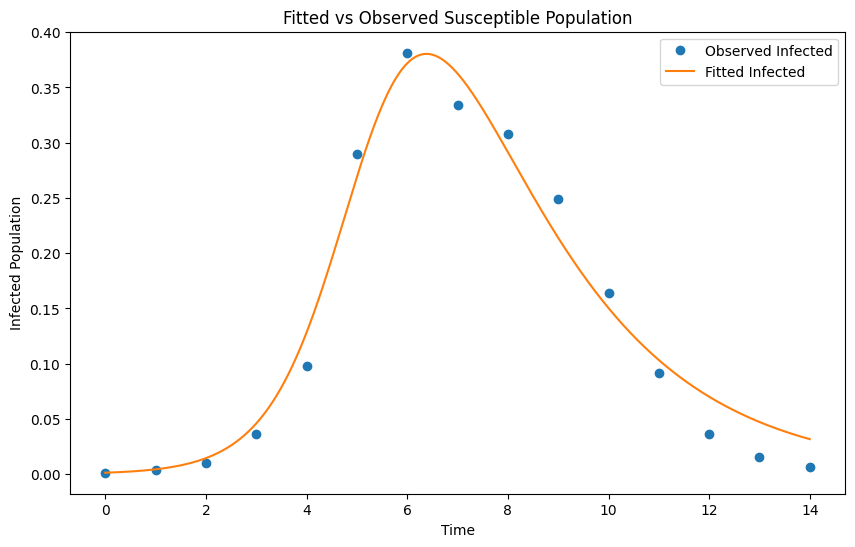

In [22]:
time_school = len(school_data)

best_model = baseSIR(*best_params, school_data[0])
best_data = best_model.numerical_integration(time_school-1)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, time_school), school_data, "o", label="Observed Infected")
plt.plot(best_data[:, 0], best_data[:, 2], "-", label="Fitted Infected")
plt.xlabel("Time")
plt.ylabel("Infected Population")
plt.title("Fitted vs Observed Susceptible Population")
plt.legend()
plt.show()

In [23]:
class flatVaccinationSIR(baseSIR):
    def __init__(self, beta: float, gamma: float, I0: float, vaccination_rate: float):
        """
        Initialize SIR model with vaccination parameters
        """
        super().__init__(beta, gamma, I0)
        self.vaccination_rate = vaccination_rate

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I - self.vaccination_rate * S

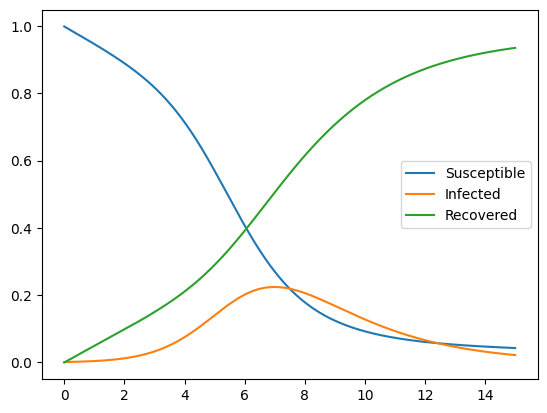

Reduction of peak: -41.00880373917713


In [24]:
basevax_model = flatVaccinationSIR(
    *best_params, I0=school_data[0], vaccination_rate=0.05
)
basevax_data = basevax_model.numerical_integration(t=time_school, dt=0.01)
plt.plot(basevax_data[:, 0], basevax_data[:, 1], label="Susceptible")
plt.plot(basevax_data[:, 0], basevax_data[:, 2], label="Infected")
plt.plot(basevax_data[:, 0], basevax_data[:, 3], label="Recovered")
plt.legend()
plt.show()

percentage_reduction = (
    (max(basevax_data[:, 2]) - max(best_data[:, 2])) / max(best_data[:, 2]) * 100
)

print(f"Reduction of peak: {percentage_reduction}")

In [32]:
class demographySIR(baseSIR):
    def __init__(self, beta: float, gamma: float, I0: float, birth_rate: float):
        """
        Initialize SIR model with demography parameters
        """
        super().__init__(beta, gamma, I0)
        self.birth_rate = birth_rate

    def dSdt(self, S, I):
        """
        Differential equation for susceptible population including demography.
        """
        return self.birth_rate - self.beta * S * I - self.birth_rate * S

    def dIdt(self, S, I):
        """
        Differential equation for infected population including demography.
        """
        return self.beta * S * I - I * self.gamma - I*self.birth_rate
    
    def dRdt(self, I, R):
        return self.gamma * I - self.birth_rate * R

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method, including infection-induced mortality.
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        delta_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I
        self.R += delta_R


In [28]:
from scipy.linalg import eig
import math


def compute_period_oscillations(beta, gamma, mu):
    """
    Compute the period of oscillations for the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - The period of oscillations.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Compute parameters for oscillation period formula
    A = 1 / (mu * (reproductive_number - 1))
    G = 1 / (mu + gamma)
    
    # Return the oscillation period
    return 1 / (2 * math.pi * np.sqrt(A * G))


def decay_rate(beta, gamma, mu):
    """
    Compute the decay rate of oscillations in the system.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - Decay rate.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Return the decay rate
    return -(mu * reproductive_number / 2)

def eigenvalue_analysis(beta, gamma, mu):
    """
    Perform an eigenvalue analysis to assess the stability of the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate
    
    Raises:
    - ValueError: If the reproductive number (R0) is less than or equal to 1.
    """
    reproductive_number = beta / (gamma + mu)

    # Ensure R0 > 1 for an endemic equilibrium
    if reproductive_number <= 1:
        raise ValueError("R0 must be greater than 1 for an endemic equilibrium.")
    
    # Calculate endemic equilibrium points
    S_equil = (gamma + mu) / beta
    I_equil = (mu / beta) * (reproductive_number - 1)

    # Construct the Jacobian matrix at the endemic equilibrium
    J = np.array([[-beta * I_equil - mu, -beta * S_equil],
                  [beta * I_equil, beta * S_equil - (gamma + mu)]])

    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues, _ = eig(J)
    print(f"Eigenvalues of the Jacobian: {eigenvalues}")
    
    # Check stability based on the real parts of the eigenvalues
    if np.all(np.real(eigenvalues) < 0):
        print("The endemic equilibrium is stable.")
    else:
        print("The endemic equilibrium is not stable.")

    # Check for damped oscillations based on the imaginary parts of the eigenvalues
    if np.any(np.imag(eigenvalues) != 0):
        print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) with damped oscillations.")
        print(f"The system has an oscillation period of {compute_period_oscillations(beta, gamma, mu)} and decay rate of {decay_rate(beta, gamma, mu)}")
    else:
        print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) without oscillations.")




In [56]:
beta = 1
gamma = 0.3
mu =  1/20
eigenvalue_analysis(beta, gamma, mu)


Eigenvalues of the Jacobian: [-0.07142857+0.16552329j -0.07142857-0.16552329j]
The endemic equilibrium is stable.
The system approaches the endemic equilibrium (S: 0.35, I: 0.09285714285714286) with damped oscillations.
The system has an oscillation period of 0.028692065403069095 and decay rate of -0.07142857142857144


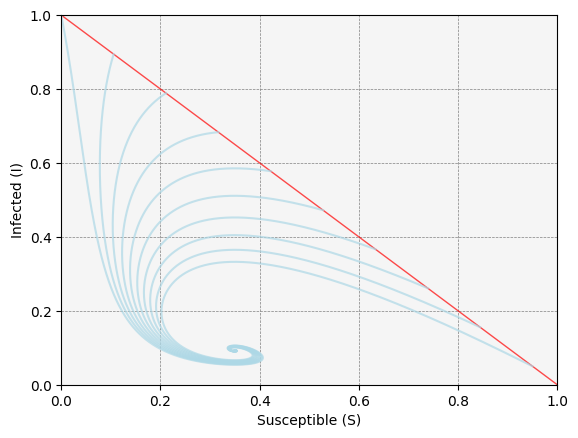

In [55]:
endemic_t = 200
endemic_dt = 0.005
endemic_agent = demographySIR(1, 0.3, 0.01, 1/20).numerical_integration(t = endemic_t, dt = endemic_dt)
phase_diagram(demographySIR, beta= 1, gamma =0.3, birth_rate= 1/20, I0_values = I0_values, t= endemic_t, dt= endemic_dt)

In [57]:
eigenvalue_analysis(beta, gamma, mu)
np.round(endemic_agent[-1, 1:3],6)

Eigenvalues of the Jacobian: [-0.07142857+0.16552329j -0.07142857-0.16552329j]
The endemic equilibrium is stable.
The system approaches the endemic equilibrium (S: 0.35, I: 0.09285714285714286) with damped oscillations.
The system has an oscillation period of 0.028692065403069095 and decay rate of -0.07142857142857144


array([0.35    , 0.092857])

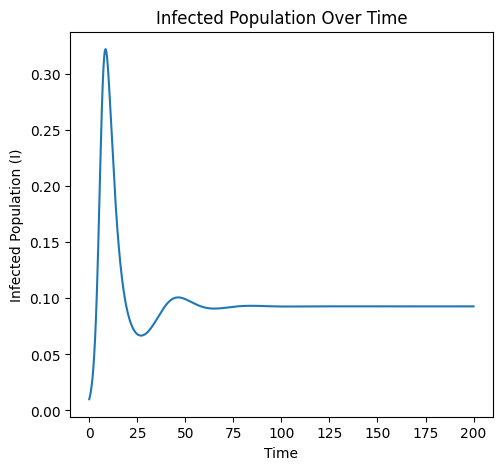

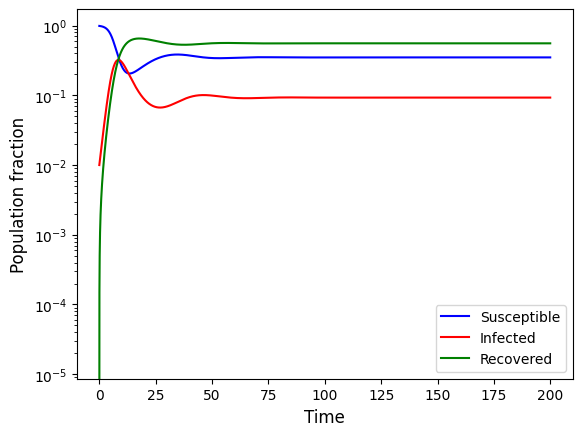

In [58]:
time_plot = endemic_agent[:,0]
# Plot the infected population over time
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time_plot, endemic_agent[:,2])
plt.title('Infected Population Over Time')
plt.xlabel('Time')
plt.ylabel('Infected Population (I)')
plt.show()

plt.plot(time_plot, endemic_agent[:,1], 'b-', label='Susceptible')
plt.plot(time_plot, endemic_agent[:,2], 'r-', label='Infected')
plt.plot(time_plot, endemic_agent[:,3], 'g-', label='Recovered')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Population fraction', fontsize=12)
plt.yscale('log')
plt.legend()

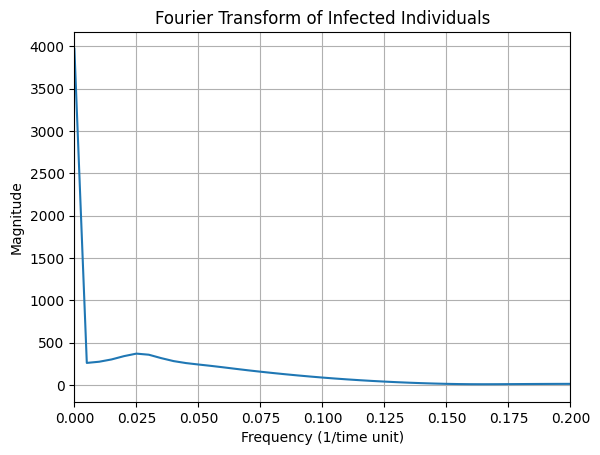

In [60]:
n = len(endemic_agent)  # Length of the data
fourier = fft.fft(endemic_agent[:, 2])
freqs = fft.fftfreq(n, d=endemic_dt)  # Correctly compute frequencies based on time step

# Consider only positive frequencies
positive_freqs = freqs[freqs >= 0]
abs_fourier = np.abs(fourier[:len(positive_freqs)])  # Only take the positive frequencies

# Plotting
plt.plot(positive_freqs, abs_fourier)
plt.xlim(0, 0.2)  # Adjust the x-axis limit to focus on the range of interest
plt.xlabel('Frequency (1/time unit)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform of Infected Individuals')
plt.grid()
plt.show()


In [145]:
class mortalitySIR(demographySIR):
    def __init__(
        self,
        beta: float,
        gamma: float,
        I0: float,
        birth_rate: float,
        mortality_probability: float,
    ):
        super().__init__(beta, gamma, I0, birth_rate)
        self.mortality_probability = mortality_probability
        self.S = 1 - I0  # Assume initial S is 1 - I0
        self.I = I0
        self.R = 0
        self.track_population = [self.S+self.I+self.R]

    def dIdt(self, S, I):
        """
        Differential equation for infected population including demography.
        """
        return self.beta * S * I - I*((self.gamma + self.birth_rate)/(1-self.mortality_probability))

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method, including infection-induced mortality.
        """
        update_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        update_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        update_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)

        self.S += update_S
        self.I += update_I
        self.R += update_R

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.arange(0, t + dt, dt)
        print(times)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)
        
        self.track_population.append(S_values[-1]+I_values[-1] + R_values[-1])

        return np.column_stack((times, S_values, I_values, R_values))

[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]
[  0.     0.01   0.02 ... 299.98 299.99 300.  ]


TypeError: mortalitySIR.__init__() got an unexpected keyword argument 'ax'

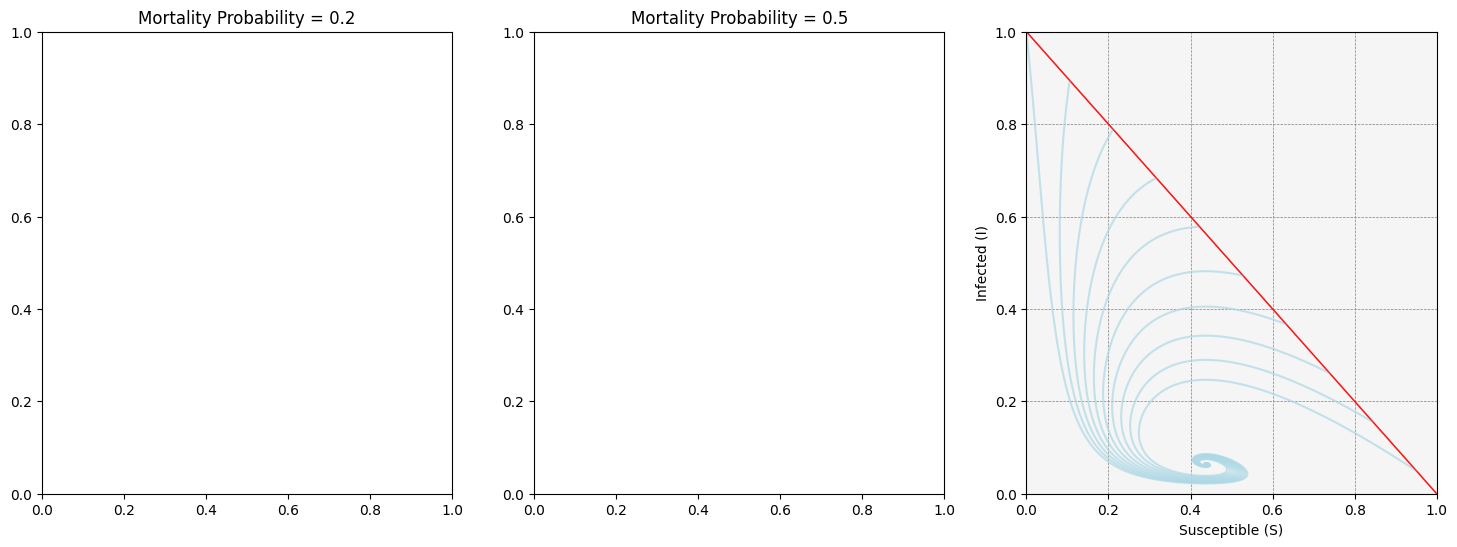

In [151]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# First plot
axes[0].set_title('Mortality Probability = 0.2')
phase_diagram(mortalitySIR, beta= 1, gamma =0.3, birth_rate= 1/20, I0_values = I0_values, t= 300, dt= 0.01, mortality_probability = 0.2)

# Second plot
axes[1].set_title('Mortality Probability = 0.5')
phase_diagram(mortalitySIR, beta= 1, gamma =0.3, birth_rate= 1/20, I0_values = I0_values, t= 300, dt= 0.01, mortality_probability = 0.5)

# Third plot
axes[2].set_title('Mortality Probability = 0.75')
phase_diagram(mortalitySIR, beta= 1, gamma =0.3, birth_rate= 1/20, I0_values = I0_values, t= 300, dt= 0.01, mortality_probability = 0.75)

for ax in axes:
    ax.set_xlabel('S (Susceptible)')
    ax.set_ylabel('I (Infected)')

plt.tight_layout()
plt.show()


In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function for Runge-Kutta 4th order (RK4) method
def RK4(func, y, step_size=0.01):
    k1 = step_size * func(*y)
    k2 = step_size * func(*(np.array(y) + 0.5 * k1))
    k3 = step_size * func(*(np.array(y) + 0.5 * k2))
    k4 = step_size * func(*(np.array(y) + k3))
    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

# SEIR model with seasonal forcing and natural birth/death rate
class seasonalSEIR_birth_death(baseSIR):
    def __init__(self, beta: float, gamma: float, sigma: float, I0: float, E0: float, A0: float, T0: float, r: float, mu: float, forcing_type: str = 'linear'):
        super().__init__(beta, gamma, I0)
        self.sigma = sigma
        self.E = E0
        self.A0 = A0  # Base amplitude for seasonal forcing
        self.T0 = T0  # Initial temperature
        self.r = r  # Rate of temperature change
        self.mu = mu  # Birth/Death rate
        self.forcing_type = forcing_type

    def temperature(self, t):
        if self.forcing_type == 'linear':
            return self.T0 + self.r * t
        elif self.forcing_type == 'exponential':
            return self.T0 * np.exp(self.r * t)
        else:
            raise ValueError("Forcing type must be either 'linear' or 'exponential'")

    def beta_t(self, t):
        T_t = self.temperature(t)
        A_t = self.A0 * (1 + (T_t / self.T0))
        return self.beta * (1 + A_t * np.sin(2 * np.pi * t / 365))

    def dSdt(self, S, I, t):
        beta_t = self.beta_t(t)
        return self.mu * (1 - S) - beta_t * S * I

    def dEdt(self, S, I, E, t):
        beta_t = self.beta_t(t)
        return beta_t * S * I - (self.sigma + self.mu) * E

    def dIdt(self, E, I) -> float:
        return self.sigma * E - (self.gamma + self.mu) * I

    def dRdt(self, I, R) -> float:
        return self.gamma * I - self.mu * R

    def update_step(self, t, dt=0.01):
        delta_S = RK4(self.dSdt, (self.S, self.I, t), step_size=dt)
        delta_E = RK4(self.dEdt, (self.S, self.I, self.E, t), step_size=dt)
        delta_I = RK4(self.dIdt, (self.E, self.I), step_size=dt)
        delta_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)
        
        self.S += delta_S
        self.E += delta_E
        self.I += delta_I
        self.R += delta_R

    def numerical_integration(self, t: int, dt: float = 0.01):
        times = np.linspace(0, t, int(t / dt) + 1)
        S_values = [self.S]
        E_values = [self.E]
        I_values = [self.I]
        R_values = [self.R]

        for time in times[1:]:
            self.update_step(time, dt)
            S_values.append(self.S)
            E_values.append(self.E)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, E_values, I_values, R_values))

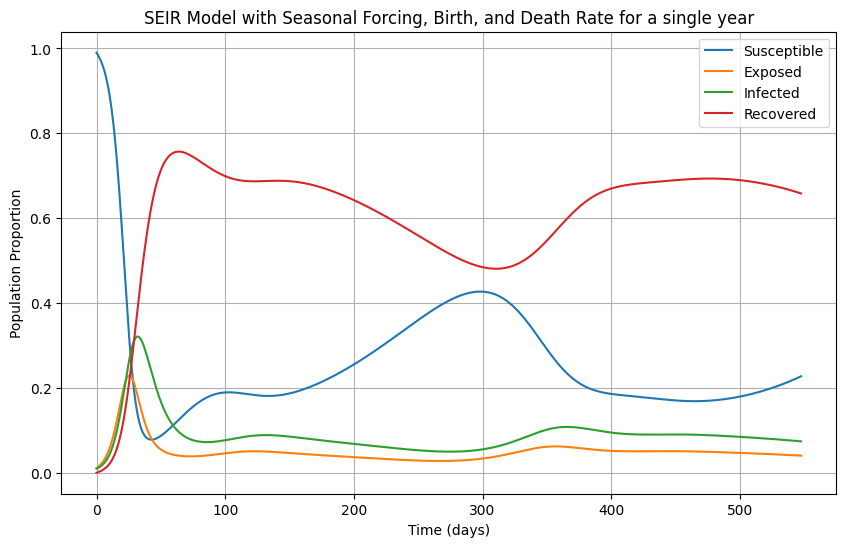

In [116]:

mu_us_lifespan = 1 / 78.5  # ~0.01274

# Initialize the model with birth and death rates
seir_birth_death_model = seasonalSEIR_birth_death(beta=0.5, gamma=0.1, sigma=0.2, I0=0.01, E0=0.01, A0=0.2, T0=15, r=0.001, mu=mu_us_lifespan, forcing_type='linear')

# Running the model
result_birth_death = seir_birth_death_model.numerical_integration(t=365*1.5, dt=0.1)

# Plotting the result
times, S_values, E_values, I_values, R_values = result_birth_death.T

plt.figure(figsize=(10, 6))
plt.plot(times, S_values, label='Susceptible')
plt.plot(times, E_values, label='Exposed')
plt.plot(times, I_values, label='Infected')
plt.plot(times, R_values, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Population Proportion')
plt.title('SEIR Model with Seasonal Forcing, Birth, and Death Rate for a single year')
plt.legend()
plt.grid(True)
plt.show()


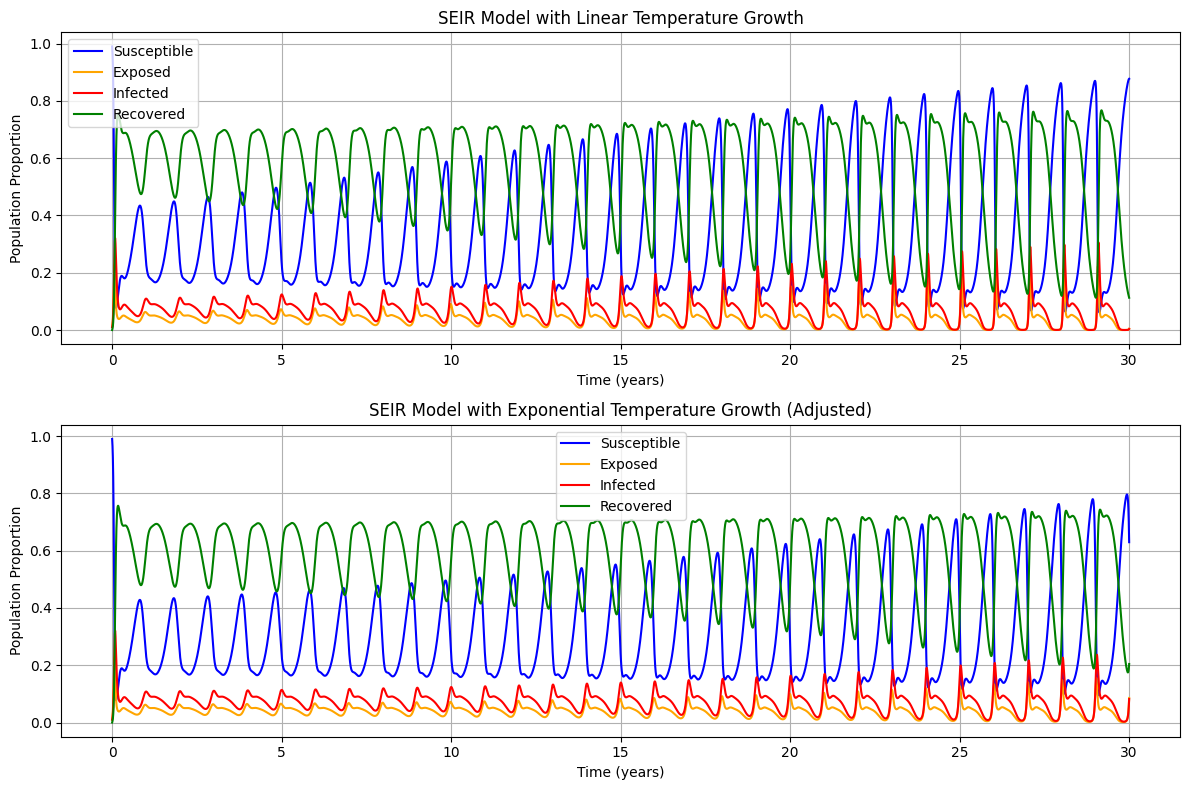

In [127]:

# Scenario 1: Linear temperature growth
seir_model_linear = seasonalSEIR_birth_death(beta=0.5, gamma=0.1, sigma=0.2, I0=0.01, E0=0.01, A0=0.2, T0=20, r=0.001, mu=mu_us_lifespan, forcing_type='linear')

# Scenario 2: Exponential temperature growth
seir_model_exponential = seasonalSEIR_birth_death(beta=0.5, gamma=0.1, sigma=0.2, I0=0.01, E0=0.01, A0=0.2, T0=20, r=0.0002, mu=mu_us_lifespan, forcing_type='exponential')

# Running the models for the next 30 years (365 * 30 days)
result_linear = seir_model_linear.numerical_integration(t=365 * 30, dt=0.1)
result_exponential = seir_model_exponential.numerical_integration(t=365 * 30, dt=0.1)

# Plotting the results for comparison
times, S_values_linear, E_values_linear, I_values_linear, R_values_linear = result_linear.T
times, S_values_exp, E_values_exp, I_values_exp, R_values_exp = result_exponential.T

plt.figure(figsize=(12, 8))

# Plot 1: Linear Temperature Growth
plt.subplot(2, 1, 1)
plt.plot(times / 365, S_values_linear, label='Susceptible', color='blue')
plt.plot(times / 365, E_values_linear, label='Exposed', color='orange')
plt.plot(times / 365, I_values_linear, label='Infected', color='red')
plt.plot(times / 365, R_values_linear, label='Recovered', color='green')
plt.xlabel('Time (years)')
plt.ylabel('Population Proportion')
plt.title('SEIR Model with Linear Temperature Growth')
plt.legend()
plt.grid(True)

# Plot 2: Exponential Temperature Growth (Adjusted)
plt.subplot(2, 1, 2)
plt.plot(times / 365, S_values_exp, label='Susceptible', color='blue')
plt.plot(times / 365, E_values_exp, label='Exposed', color='orange')
plt.plot(times / 365, I_values_exp, label='Infected', color='red')
plt.plot(times / 365, R_values_exp, label='Recovered', color='green')
plt.xlabel('Time (years)')
plt.ylabel('Population Proportion')
plt.title('SEIR Model with Exponential Temperature Growth (Adjusted)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


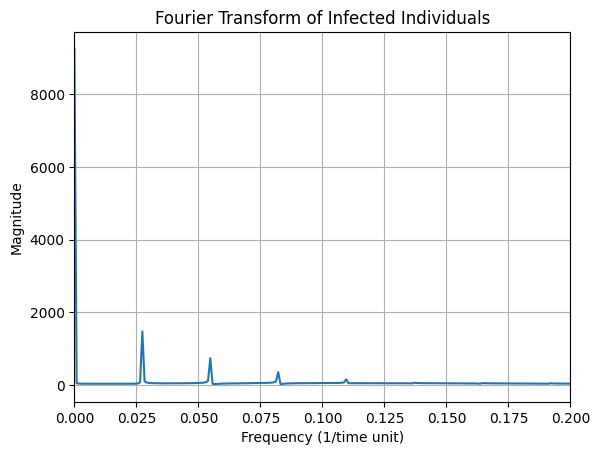

In [115]:
n = len(result_linear)  # Length of the data
fourier = fft.fft(result_linear[:, 3])
freqs = fft.fftfreq(n, d=0.01)  # Correctly compute frequencies based on time step

# Consider only positive frequencies
positive_freqs = freqs[freqs >= 0]
abs_fourier = np.abs(fourier[:len(positive_freqs)])  # Only take the positive frequencies

# Plotting
plt.plot(positive_freqs, abs_fourier)
plt.xlim(0, 0.2)  # Adjust the x-axis limit to focus on the range of interest
plt.xlabel('Frequency (1/time unit)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform of Infected Individuals')
plt.grid()
plt.show()


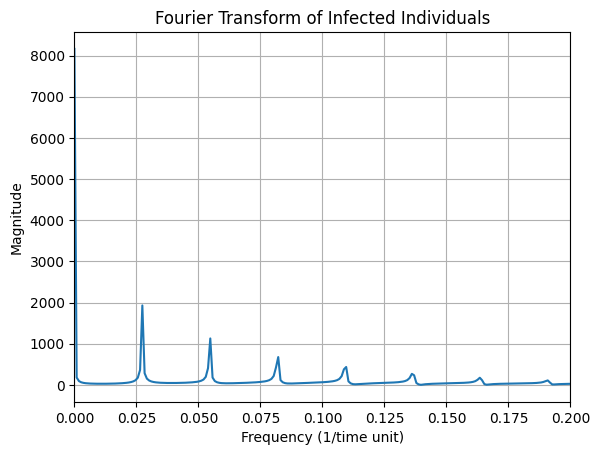

In [149]:
n = len(result_exponential)  # Length of the data
fourier = fft.fft(result_exponential[:, 3])
freqs = fft.fftfreq(n, d=0.01)  # Correctly compute frequencies based on time step

# Consider only positive frequencies
positive_freqs = freqs[freqs >= 0]
abs_fourier = np.abs(fourier[:len(positive_freqs)])  # Only take the positive frequencies

# Plotting
plt.plot(positive_freqs, abs_fourier)
plt.xlim(0, 0.2)  # Adjust the x-axis limit to focus on the range of interest
plt.xlabel('Frequency (1/time unit)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform of Infected Individuals')
plt.grid()
plt.show()


In [143]:
# SEIR model with sinusoidal seasonal forcing (common cold)
class SEIR_common_cold:
    def __init__(self, beta: float, gamma: float, sigma: float, I0: float, E0: float, A0: float, T0: float, mu: float):
        self.beta = beta       # Base transmission rate
        self.gamma = gamma     # Recovery rate
        self.sigma = sigma     # Incubation rate (E -> I)
        self.mu = mu           # Birth/Death rate
        self.S = 1 - I0 - E0   # Initial susceptible population (assuming R0 = 0 initially)
        self.E = E0            # Initial exposed population
        self.I = I0            # Initial infected population
        self.R = 0             # Initial recovered population
        self.A0 = A0           # Seasonal forcing amplitude
        self.T0 = T0           # Period of sinusoidal temperature change (1 year)

    # Sinusoidal seasonal temperature forcing
    def temperature(self, t):
        # Sinusoidal temperature variation over a year
        return self.A0 * np.sin(2 * np.pi * (t / 365 + 0.5))

    # Transmission rate that increases in colder conditions
    def beta_t(self, t):
        T_t = self.temperature(t)
        return self.beta * (1 - T_t)  # Transmission inversely related to temperature (increases in cold)

    # Susceptible population differential equation
    def dSdt(self, S, I, t):
        beta_t = self.beta_t(t)
        return self.mu * (1 - S) - beta_t * S * I

    # Exposed population differential equation
    def dEdt(self, S, I, E, t):
        beta_t = self.beta_t(t)
        return beta_t * S * I - (self.sigma + self.mu) * E

    # Infected population differential equation
    def dIdt(self, E, I):
        return self.sigma * E - (self.gamma + self.mu) * I

    # Recovered population differential equation
    def dRdt(self, I, R):
        return self.gamma * I - self.mu * R

    # Update step using RK4 method
    def update_step(self, t, dt=0.01):
        delta_S = RK4(self.dSdt, (self.S, self.I, t), step_size=dt)
        delta_E = RK4(self.dEdt, (self.S, self.I, self.E, t), step_size=dt)
        delta_I = RK4(self.dIdt, (self.E, self.I), step_size=dt)
        delta_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)
        
        self.S += delta_S
        self.E += delta_E
        self.I += delta_I
        self.R += delta_R

    # Numerical integration over time
    def numerical_integration(self, t: int, dt: float = 0.01):
        times = np.linspace(0, t, int(t / dt) + 1)
        S_values = [self.S]
        E_values = [self.E]
        I_values = [self.I]
        R_values = [self.R]

        for time in times[1:]:
            self.update_step(time, dt)
            S_values.append(self.S)
            E_values.append(self.E)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, E_values, I_values, R_values))

# Helper function for Runge-Kutta 4th order (RK4) method
def RK4(func, y, step_size=0.01):
    k1 = step_size * func(*y)
    k2 = step_size * func(*(np.array(y) + 0.5 * k1))
    k3 = step_size * func(*(np.array(y) + 0.5 * k2))
    k4 = step_size * func(*(np.array(y) + k3))
    return (k1 + 2 * k2 + 2 * k3 + k4) / 6


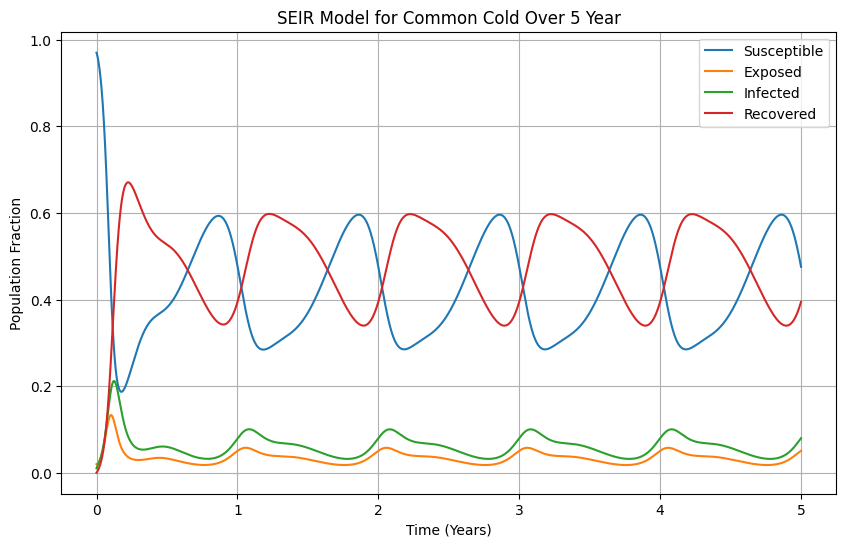

In [144]:

beta = 0.3       # Base transmission rate
gamma = 0.1      # Recovery rate
sigma = 0.2      # Incubation rate
I0 = 0.01        # Initial infected population
E0 = 0.02        # Initial exposed population
A0 = 0.3         # Seasonal forcing amplitude
T0 = 1           # Average temperature
mu = 1 / 80      # Birth/Death rate (average lifespan of 80 years)

# Initialize the SEIR model for the common cold
seir_model = SEIR_common_cold(beta, gamma, sigma, I0, E0, A0, T0, mu)

# Run the model over 365 days (1 year)
results = seir_model.numerical_integration(t=365*5, dt=0.1)

# Extract time, S, E, I, R values from the results
time = results[:, 0] /365
S_values = results[:, 1]
E_values = results[:, 2]
I_values = results[:, 3]
R_values = results[:, 4]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, S_values, label='Susceptible')
plt.plot(time, E_values, label='Exposed')
plt.plot(time, I_values, label='Infected')
plt.plot(time, R_values, label='Recovered')

plt.title('SEIR Model for Common Cold Over 5 Year')
plt.xlabel('Time (Years)')
plt.ylabel('Population Fraction')
plt.legend()
plt.grid(True)
plt.show()